<a href="https://colab.research.google.com/github/jsalafica/Data-Science-I/blob/master/Modelo2_NYC_Accidents_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd

# 1. Cargar el dataset
url = 'https://raw.githubusercontent.com/jsalafica/Data-Science-I/master/NYC_Accidents_2020.csv'
df = pd.read_csv(url)

# 2. Crear variable objetivo binaria: HERIDOS
df['HERIDOS'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)

# 3. Extraer la hora como valor numérico
df['HORA'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M:%S', errors='coerce').dt.hour

# 4. Filtrar columnas útiles
df_model = df[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1', 'HERIDOS']].dropna()

# Vista previa
df_model.head()


,HORA,BOROUGH,VEHICLE TYPE CODE 1,CONTRIBUTING FACTOR VEHICLE 1,HERIDOS
0,15,BRONX,Sedan,Passing Too Closely,0
1,21,BROOKLYN,Sedan,Reaction to Uninvolved Vehicle,1
3,0,BRONX,Station Wagon/Sport Utility Vehicle,Unsafe Speed,0
4,17,BROOKLYN,Sedan,Failure to Yield Right-of-Way,0
6,19,BRONX,Station Wagon/Sport Utility Vehicle,Unspecified,0


In [8]:
from sklearn.preprocessing import LabelEncoder

# Creamos codificadores para cada variable categórica
le_borough = LabelEncoder()
le_vehiculo = LabelEncoder()
le_factor = LabelEncoder()

# Aplicamos codificación
df_model['BOROUGH'] = le_borough.fit_transform(df_model['BOROUGH'])
df_model['VEHICLE TYPE CODE 1'] = le_vehiculo.fit_transform(df_model['VEHICLE TYPE CODE 1'])
df_model['CONTRIBUTING FACTOR VEHICLE 1'] = le_factor.fit_transform(df_model['CONTRIBUTING FACTOR VEHICLE 1'])

# Verificamos
df_model.head()


,HORA,BOROUGH,VEHICLE TYPE CODE 1,CONTRIBUTING FACTOR VEHICLE 1,HERIDOS
0,15,0,142,30,0
1,21,1,142,37,1
3,0,0,144,47,0
4,17,1,142,14,0
6,19,0,144,48,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Separar features y target
X = df_model[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y = df_model['HERIDOS']

# 2. Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Entrenar el modelo
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# 4. Predecir y evaluar
y_pred = rf.predict(X_test)

# 5. Mostrar resultados
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# Mostrar importancia de las variables
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.title("Importancia de las variables en el modelo Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [11]:
def predecir_heridos(hora, borough, vehiculo, factor):
    # Armar DataFrame con los datos del accidente
    df_nuevo = pd.DataFrame([{
        'HORA': hora,
        'BOROUGH': borough,
        'VEHICLE TYPE CODE 1': vehiculo,
        'CONTRIBUTING FACTOR VEHICLE 1': factor
    }])

    # Codificar usando los mismos labelencoders entrenados
    try:
        df_nuevo['BOROUGH'] = le_borough.transform(df_nuevo['BOROUGH'])
        df_nuevo['VEHICLE TYPE CODE 1'] = le_vehiculo.transform(df_nuevo['VEHICLE TYPE CODE 1'])
        df_nuevo['CONTRIBUTING FACTOR VEHICLE 1'] = le_factor.transform(df_nuevo['CONTRIBUTING FACTOR VEHICLE 1'])
    except ValueError as e:
        return f"❌ Error: valor desconocido - {e}"

    # Predecir
    pred = rf.predict(df_nuevo)[0]
    prob = rf.predict_proba(df_nuevo)[0][1]  # Probabilidad de clase 1 (heridos)

    return f"✅ Probabilidad de heridos: {prob:.2%} → {'HERIDOS' if pred == 1 else 'NO HERIDOS'}"


In [18]:
# Probar con un caso real
predecir_heridos(
    hora=14,
    borough='MANHATTAN',
    vehiculo='Sedan',
    factor='Driver Inattention/Distraction'
)

'✅ Probabilidad de heridos: 31.79% → NO HERIDOS'

In [19]:
def predecir_heridos_lote(path_csv):
    # Cargar CSV con accidentes nuevos
    df_nuevos = pd.read_csv(path_csv)

    # Normalizar formato de columnas
    df_nuevos['BOROUGH'] = df_nuevos['BOROUGH'].str.upper().str.strip()
    df_nuevos['VEHICLE TYPE CODE 1'] = df_nuevos['VEHICLE TYPE CODE 1'].str.strip()
    df_nuevos['CONTRIBUTING FACTOR VEHICLE 1'] = df_nuevos['CONTRIBUTING FACTOR VEHICLE 1'].str.strip()

    # Codificar con LabelEncoders entrenados
    try:
        df_nuevos['BOROUGH'] = le_borough.transform(df_nuevos['BOROUGH'])
        df_nuevos['VEHICLE TYPE CODE 1'] = le_vehiculo.transform(df_nuevos['VEHICLE TYPE CODE 1'])
        df_nuevos['CONTRIBUTING FACTOR VEHICLE 1'] = le_factor.transform(df_nuevos['CONTRIBUTING FACTOR VEHICLE 1'])
    except ValueError as e:
        return f"❌ Error de codificación: {e}"

    # Hacer predicciones
    predicciones = rf.predict(df_nuevos)
    probabilidades = rf.predict_proba(df_nuevos)[:, 1]

    # Agregar resultados
    df_nuevos['PRED_HERIDOS'] = predicciones
    df_nuevos['PROB_HERIDOS'] = probabilidades

    return df_nuevos

In [26]:
resultado = predecir_heridos_lote('https://github.com/jsalafica/Data-Science-I/raw/refs/heads/master/accidentes_nuevos.csv')
resultado

,HORA,BOROUGH,VEHICLE TYPE CODE 1,CONTRIBUTING FACTOR VEHICLE 1,PRED_HERIDOS,PROB_HERIDOS
0,15,0,142,30,0,0.286083
1,21,1,142,37,0,0.232428
2,0,0,144,47,0,0.327902
3,17,1,142,14,1,0.783226
4,19,0,144,48,0,0.402700
5,20,2,142,47,0,0.354411


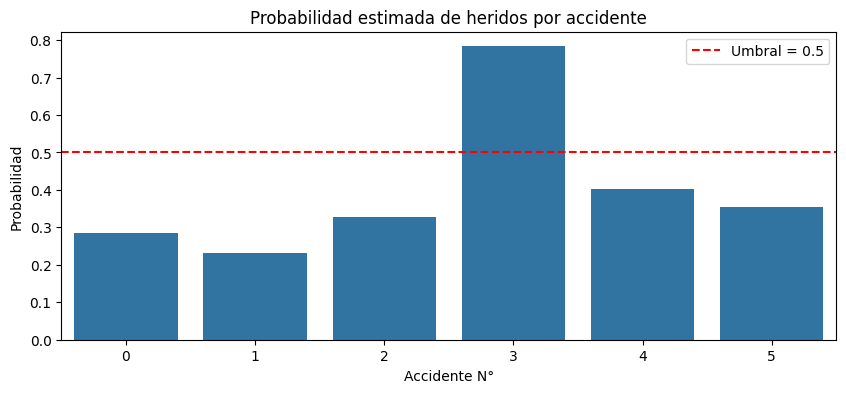

In [27]:
# Visualizar la probabilidad de heridos para cada caso
plt.figure(figsize=(10, 4))
sns.barplot(x=resultado.index, y=resultado['PROB_HERIDOS'])
plt.axhline(0.5, color='red', linestyle='--', label='Umbral = 0.5')
plt.title('Probabilidad estimada de heridos por accidente')
plt.xlabel('Accidente N°')
plt.ylabel('Probabilidad')
plt.legend()
plt.show()

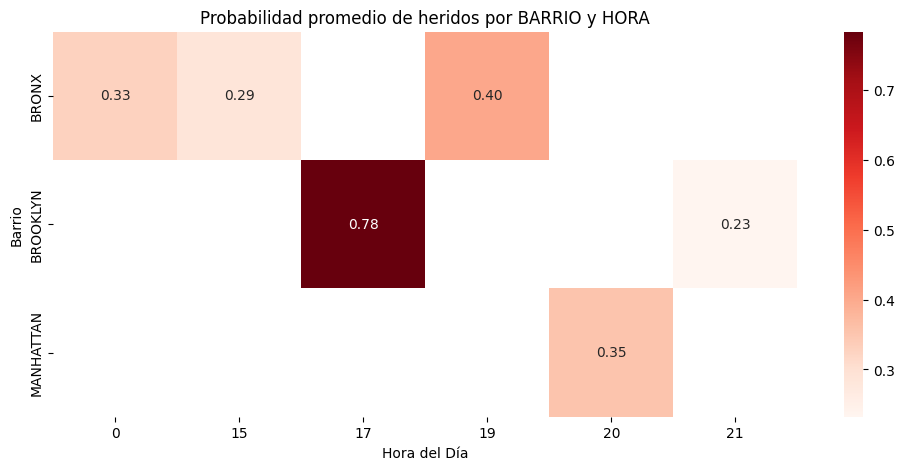

In [28]:
# Cargar datos originales de entrada con predicciones
df_heatmap = resultado.copy()
df_heatmap['BOROUGH_NOMBRE'] = le_borough.inverse_transform(df_heatmap['BOROUGH'])

# Agrupar por BARRIO y HORA
pivot = df_heatmap.pivot_table(index='BOROUGH_NOMBRE', columns='HORA', values='PROB_HERIDOS', aggfunc='mean')

# Graficar mapa de calor
plt.figure(figsize=(12, 5))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt=".2f")
plt.title('Probabilidad promedio de heridos por BARRIO y HORA')
plt.xlabel('Hora del Día')
plt.ylabel('Barrio')
plt.show()

In [25]:
resultado.to_csv('predicciones_con_heridos.csv', index=False)

### 🧾 Conclusión

A partir de los datos procesados por el modelo de Random Forest, se estimó la probabilidad de que un accidente de tránsito derive en personas heridas, considerando variables como el barrio (`BOROUGH`), la hora del día (`HORA`), el tipo de vehículo involucrado y el factor contribuyente.

Las visualizaciones permiten observar lo siguiente:

- El **mapa de calor** muestra que ciertos barrios presentan mayor riesgo en horarios específicos. Por ejemplo, en BROOKLYN durante la tarde (17 hs), la probabilidad de heridos se eleva significativamente.
- El **gráfico de barras individual** refuerza esta observación al identificar un único accidente con probabilidad alta (78%), lo que coincide con un caso realista: `Failure to Yield Right-of-Way` en BROOKLYN a las 17 hs.
- El resto de los accidentes presentan probabilidades menores al umbral de alerta (0.5), por lo cual el modelo los clasifica como de bajo riesgo.

Este análisis demuestra cómo un modelo predictivo puede ser utilizado como una herramienta de **priorización de eventos** para servicios de emergencia o análisis preventivo en políticas de tránsito.


# Predictor con select x hora, municipio, tipo de vehiculo y factor

In [29]:
import ipywidgets as widgets
from IPython.display import display

# Obtener opciones únicas desde los LabelEncoders
boroughs = list(le_borough.classes_)
vehiculos = list(le_vehiculo.classes_)
factores = list(le_factor.classes_)

# Crear widgets
hora_input = widgets.IntSlider(value=12, min=0, max=23, step=1, description='Hora:')
borough_input = widgets.Dropdown(options=boroughs, description='Borough:')
vehiculo_input = widgets.Dropdown(options=vehiculos, description='Vehículo:')
factor_input = widgets.Dropdown(options=factores, description='Factor:')

output = widgets.Output()

# Función para predecir y mostrar resultado
def hacer_prediccion(change=None):
    df_nuevo = pd.DataFrame([{
        'HORA': hora_input.value,
        'BOROUGH': borough_input.value,
        'VEHICLE TYPE CODE 1': vehiculo_input.value,
        'CONTRIBUTING FACTOR VEHICLE 1': factor_input.value
    }])

    # Codificar
    df_nuevo['BOROUGH'] = le_borough.transform(df_nuevo['BOROUGH'])
    df_nuevo['VEHICLE TYPE CODE 1'] = le_vehiculo.transform(df_nuevo['VEHICLE TYPE CODE 1'])
    df_nuevo['CONTRIBUTING FACTOR VEHICLE 1'] = le_factor.transform(df_nuevo['CONTRIBUTING FACTOR VEHICLE 1'])

    # Predecir
    prob = rf.predict_proba(df_nuevo)[0][1]
    pred = rf.predict(df_nuevo)[0]

    with output:
        output.clear_output()
        print(f"🧠 Probabilidad de heridos: {prob:.2%}")
        print("✅ Predicción:", "HERIDOS" if pred == 1 else "NO HERIDOS")

# Botón para ejecutar
boton = widgets.Button(description="Predecir")
boton.on_click(hacer_prediccion)

# Mostrar formulario
display(hora_input, borough_input, vehiculo_input, factor_input, boton, output)


IntSlider(value=12, description='Hora:', max=23)

Dropdown(description='Borough:', options=('BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'), value=…

Dropdown(description='Vehículo:', options=('0', '18 WHEELER', '2 dr sedan', '3-Door', '4 dr sedan', 'AMB', 'AM…

Dropdown(description='Factor:', options=('Accelerator Defective', 'Aggressive Driving/Road Rage', 'Alcohol Inv…

Button(description='Predecir', style=ButtonStyle())

Output()